# Variability

Investigate the differences in transcriptome variability between drugs that target the same system

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data_path = '/data_volume/memento/sciplex/'

In [5]:
ct = 'A549'

In [6]:
adata = sc.read(data_path + 'h5ad/{}_HDAC.h5ad'.format(ct))

### Setup memento

In [7]:
adata.obs['q'] = 0.05

In [8]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:68: RankWarning: Polyfit may be poorly conditioned


### One sample test

In [9]:
subset = adata[(adata.obs.target == 'HDAC') & (adata.obs.dose == 10000)].copy().copy()

memento.create_groups(subset, label_columns=['product_name'])
memento.compute_1d_moments(subset, min_perc_group=.9)
memento.ht_1d_moments(
    subset, 
    formula_like='1',
    cov_column='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=90)

# subset.write(data_path + 'hdac/{}_vs_vehicle.h5ad'.format(drug))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=90)]: Using backend LokyBackend with 90 concurrent workers.
[Parallel(n_jobs=90)]: Done  20 tasks      | elapsed:    4.6s
[Parallel(n_jobs=90)]: Done 270 tasks      | elapsed:    7.9s
[Parallel(n_jobs=90)]: Done 620 tasks      | elapsed:   12.6s
[Parallel(n_jobs=90)]: Done 1070 tasks      | elapsed:   18.6s
[Parallel(n_jobs=90)]: Done 1620 tasks      | elapsed:   26.1s
[Parallel(n_jobs=90)]: Done 2326 out of 2326 | elapsed:   38.2s finished


In [10]:
df = memento.get_1d_ht_result(subset)
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

### GSEA

In [25]:
import gseapy as gp
from gseapy.plot import gseaplot


In [26]:
pre_res = gp.prerank(
    rnk=df[['gene','dv_coef']].sort_values('dv_coef'), 
    gene_sets='GO_Biological_Process_2018',
    processes=14,
    permutation_num=100, # reduce number to speed up testing
    outdir=None, seed=6)

### Compare different HDACs to vehicle

In [39]:
for drug in adata.obs.product_name.drop_duplicates():
    
    if drug == 'Vehicle':
        continue

    subset = adata[(adata.obs.dose == 10000)].copy().copy()
    subset.obs['is_drug'] = (subset.obs.product_name==drug).astype(int)
    
    memento.create_groups(subset, label_columns=['is_drug', 'product_name'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_drug',
        cov_column='is_drug', 
        num_boot=10000, 
        verbose=1,
        num_cpus=70)
    
#     subset.write(data_path + 'hdac/{}_vs_rest.h5ad'.format(drug))
    
    break

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=70)]: Using backend LokyBackend with 70 concurrent workers.
[Parallel(n_jobs=70)]: Done  60 tasks      | elapsed:    1.4s
[Parallel(n_jobs=70)]: Done 310 tasks      | elapsed:    5.1s
[Parallel(n_jobs=70)]: Done 660 tasks      | elapsed:   10.0s
[Parallel(n_jobs=70)]: Done 1110 tasks      | elapsed:   16.3s
[Parallel(n_jobs=70)]: Done 1660 tasks      | elapsed:   23.9s
[Parallel(n_jobs=70)]: Done 2326 out of 2326 | elapsed:   36.7s finished


In [40]:
df = memento.get_1d_ht_result(subset)
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

In [42]:
df.query('dv_fdr < 0.1')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr
725,TTC1,0.0,0.0,0.0001,0.0,0.0,0.0001,0.077526,0.001278
860,RBM25,0.0,0.0,0.0001,0.0,0.0,0.0001,0.077526,0.001278
2069,GTF2F2,0.0,0.0,0.0001,0.0,0.0,0.0001,0.077526,0.001278


In [36]:
drug

'Divalproex Sodium'

In [57]:
heatmap = []
for drug in adata.obs.product_name.drop_duplicates():
    
    if drug == 'Vehicle':
        continue
        
    subset = sc.read(data_path + 'hdac/{}_vs_vehicle.h5ad'.format(drug))
    df = memento.get_1d_ht_result(subset)
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    heatmap.append((drug, df.query('dv_fdr < 0.1& dv_coef < 0').shape[0], df.query('dv_fdr < 0.1 & dv_coef > 0').shape[0]))
    print(drug, df.query('de_fdr < 0.1').shape[0],df.query('dv_fdr < 0.1& dv_coef < 0').shape[0], df.query('dv_fdr < 0.1 & dv_coef > 0').shape[0])

Divalproex Sodium 1290 2 0
Abexinostat (PCI-24781) 1921 8 0
Sodium Phenylbutyrate 565 0 0
Tucidinostat (Chidamide) 1414 2 0
PCI-34051 1317 2 2
Resminostat 868 2 0
Panobinostat (LBH589) 1589 6 3
Quisinostat (JNJ-26481585) 2HCl 1798 22 16
MC1568 1107 1 0
Belinostat (PXD101) 1227 2 0
Dacinostat (LAQ824) 1708 8 8
Mocetinostat (MGCD0103) 1148 1 1
TMP195 1202 2 0
Droxinostat 215 0 0
M344 827 6 0
ITSA-1 (ITSA1) 1251 1 2
AR-42 1135 3 0
Tubastatin A HCl 632 7 0
Pracinostat (SB939) 1597 11 1
Tacedinaline (CI994) 625 14 0
Trichostatin A (TSA) 625 1 0
Entinostat (MS-275) 690 3 0
Givinostat (ITF2357) 1081 1 0


In [59]:
heatmap = pd.DataFrame(heatmap, columns=['gene', 'dv-', 'dv+'])

In [62]:
heatmap.index = heatmap.gene
heatmap = heatmap[['dv-', 'dv+']]

Text(0.5, 1.0, 'Drug vs control')

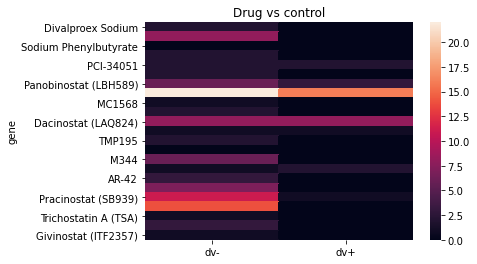

In [64]:
sns.heatmap(heatmap)
plt.title('Drug vs control')

### Drug-drug comparisons

Investigate if including the dosage changes anything

In [16]:
drug_counts = adata.obs.query('~vehicle').product_name.value_counts()
drug_list = drug_counts[drug_counts > 0].index.tolist()

In [44]:
drug_list = drug_counts[drug_counts > 0].index.tolist()
drug_list = [
    'Pracinostat (SB939)',
    'Quisinostat (JNJ-26481585) 2HCl',
    'Abexinostat (PCI-24781)',
    'Mocetinostat (MGCD0103)',
    'Divalproex Sodium',
    'M344',
    'Resminostat',
    'Panobinostat (LBH589)'
]

In [45]:
len(list(itertools.combinations(drug_list,2)))

28

In [ ]:
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    print(drug1, drug2)

    subset = adata[adata.obs.product_name.isin([drug1, drug2]) & (adata.obs.dose == 10000)].copy().copy()
    subset.obs['is_drug1'] = (subset.obs.product_name==drug1).astype(int)
    
    memento.create_groups(subset, label_columns=['is_drug1'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_drug1',
        cov_column='is_drug1', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94)
    
    subset.write(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))

In [46]:
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    print(drug1, drug2)

    subset = adata[adata.obs.product_name.isin([drug1, drug2])].copy().copy()
    subset.obs['is_drug1'] = (subset.obs.product_name==drug1).astype(int)
    subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)
    
    memento.create_groups(subset, label_columns=['is_drug1', 'dose_level'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + is_drug1',
        cov_column='is_drug1', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94)
    
    subset.write(data_path + 'hdac/{}_vs_{}_all_doses.h5ad'.format(drug1, drug2))

Pracinostat (SB939) Quisinostat (JNJ-26481585) 2HCl


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Abexinostat (PCI-24781)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Pracinostat (SB939) Mocetinostat (MGCD0103)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Pracinostat (SB939) Divalproex Sodium


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Pracinostat (SB939) M344


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Pracinostat (SB939) Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Abexinostat (PCI-24781)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Quisinostat (JNJ-26481585) 2HCl Mocetinostat (MGCD0103)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Divalproex Sodium


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl M344


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Quisinostat (JNJ-26481585) 2HCl Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Mocetinostat (MGCD0103)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Abexinostat (PCI-24781) Divalproex Sodium


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Abexinostat (PCI-24781) M344


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Abexinostat (PCI-24781) Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mocetinostat (MGCD0103) Divalproex Sodium


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Mocetinostat (MGCD0103) M344


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mocetinostat (MGCD0103) Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Mocetinostat (MGCD0103) Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Divalproex Sodium M344


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Divalproex Sodium Resminostat


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Divalproex Sodium Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


M344 Resminostat


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


M344 Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Resminostat Panobinostat (LBH589)


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


### Combine P-values

In [47]:
dv_pvals = pd.DataFrame()
start = True
for drug1, drug2 in itertools.combinations(drug_list,2):
    
    subset = sc.read(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))
    df = memento.get_1d_ht_result(subset)
    if start:
        
        dv_pvals['gene'] = df['gene']
        dv_pvals['{}_{}'.format(drug1, drug2)] = df['dv_pval']
        start = False
    else:
        dv_pvals = dv_pvals.merge(df[['gene', 'dv_pval']].rename(columns={'dv_pval':'{}_{}'.format(drug1, drug2)}), how='outer')
        
# dv_pvals = pd.DataFrame()
# start = True
# for drug1, drug2 in itertools.combinations(drug_list,2):
    
#     subset = sc.read(data_path + 'hdac/{}_vs_{}_10000.h5ad'.format(drug1, drug2))
#     df = memento.get_1d_ht_result(subset)
#     if start:
        
#         dv_pvals['gene'] = df['gene']
#         dv_pvals['{}_{}'.format(drug1, drug2)] = df['de_pval']
#         start = False
#     else:
#         dv_pvals = dv_pvals.merge(df[['gene', 'de_pval']].rename(columns={'de_pval':'{}_{}'.format(drug1, drug2)}), how='outer')

In [48]:
combined_pvals = []
for g in dv_pvals.gene:
    pvalues = dv_pvals.query('gene == "{}"'.format(g)).iloc[0, 1:].values.astype(float)
    chisq, pv = stats.combine_pvalues(pvalues[np.isfinite(pvalues)])
    combined_pvals.append((g, chisq, pv))

In [49]:
combined_pvals = pd.DataFrame(combined_pvals, columns=['gene', 'chisq', 'pv'])
combined_pvals['fdr'] = memento.util._fdrcorrect(combined_pvals['pv'])

In [50]:
combined_pvals.head(2)

,gene,chisq,pv,fdr
0,DPM1,53.117680,0.584668,0.994124
1,C1orf112,65.021334,0.012876,0.211907


### GSEA + Enrichr

In [51]:
# for gene in combined_pvals.query('fdr < 0.01').sort_values('fdr').gene:
#     print(gene)

In [52]:
import gseapy as gp
from gseapy.plot import gseaplot


In [53]:
# pre_res = gp.prerank(rnk=combined_pvals.sort_values('chisq', ascending=False)[['gene', 'chisq']], gene_sets='GO_Biological_Process_2021',
#                      processes=90,
#                      permutation_num=100, # reduce number to speed up testing
#                      outdir=None,seed=6)

In [54]:
# pre_res.res2d.sort_index().head(30)


In [55]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.05').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [56]:
enr.results.head(30)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,secondary alcohol biosynthetic process (GO:190...,5/34,0.000002,0.001099,0,0,29.761619,394.841502,IDI1;ACLY;INSIG1;DHCR24;FDFT1
1,GO_Biological_Process_2021,cholesterol biosynthetic process (GO:0006695),5/35,0.000002,0.001099,0,0,28.768116,377.364037,IDI1;ACLY;INSIG1;DHCR24;FDFT1
2,GO_Biological_Process_2021,sterol biosynthetic process (GO:0016126),5/38,0.000003,0.001117,0,0,26.148880,331.986503,IDI1;ACLY;INSIG1;DHCR24;FDFT1
3,GO_Biological_Process_2021,positive regulation of tau-protein kinase acti...,3/6,0.000004,0.001137,0,0,169.888889,2105.015788,HSP90AA1;CLU;DKK1
4,GO_Biological_Process_2021,regulation of tau-protein kinase activity (GO:...,3/10,0.000025,0.005363,0,0,72.794872,772.814864,HSP90AA1;CLU;DKK1
5,GO_Biological_Process_2021,steroid metabolic process (GO:0008202),6/104,0.000039,0.007049,0,0,10.624060,107.947284,CYP24A1;NPC1;FDXR;AKR1C2;DHCR24;FDFT1
6,GO_Biological_Process_2021,cholesterol metabolic process (GO:0008203),5/77,0.000100,0.015641,0,0,11.961353,110.158793,ACLY;IDI1;INSIG1;DHCR24;FDFT1
7,GO_Biological_Process_2021,lipid biosynthetic process (GO:0008610),5/80,0.000120,0.016415,0,0,11.481159,103.648401,ACLY;ACSS2;FDXR;FADS1;FDFT1
8,GO_Biological_Process_2021,regulation of cellular metabolic process (GO:0...,4/47,0.000180,0.021892,0,0,15.907779,137.156785,ACLY;RNF34;DKK1;RNF41
9,GO_Biological_Process_2021,aminoglycan biosynthetic process (GO:0006023),4/49,0.000212,0.023190,0,0,15.199234,128.571288,EXT1;UGDH;SDC4;GCNT2


In [57]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.05').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [58]:
enr.results.head(50)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,NRF2 pathway WP2884,9/146,2.414786e-07,0.000039,0,0,11.684553,178.031520,ABCC3;NQO1;HSP90AA1;ABCC2;TXNRD1;NRG1;SLC7A11;...
1,WikiPathways_2019_Human,Nuclear Receptors Meta-Pathway WP2882,10/319,2.282384e-05,0.001837,0,0,5.757870,61.538417,ABCC3;FGD4;NQO1;HSP90AA1;ABCC2;TXNRD1;NRG1;SLC...
2,WikiPathways_2019_Human,Metabolic reprogramming in colon cancer WP4290,4/42,1.156613e-04,0.006207,0,0,18.005445,163.216560,ACLY;PKM;PPAT;GAPDH
3,WikiPathways_2019_Human,Pathways in clear cell renal cell carcinoma WP...,5/85,1.599304e-04,0.006437,0,0,10.760870,94.058306,ACLY;PKM;PLOD2;SQSTM1;GAPDH
4,WikiPathways_2019_Human,Apoptosis-related network due to altered Notch...,4/53,2.875950e-04,0.009261,0,0,13.955665,113.793898,NQO1;TNFRSF10B;NRG1;SQSTM1
5,WikiPathways_2019_Human,Photodynamic therapy-induced NFE2L2 (NRF2) sur...,3/24,3.888451e-04,0.010434,0,0,24.247863,190.402212,ABCC3;NQO1;ABCC2
6,WikiPathways_2019_Human,Lipid Metabolism Pathway WP3965,3/29,6.868207e-04,0.014750,0,0,19.579882,142.608840,ACLY;ACSS2;ACSBG1
7,WikiPathways_2019_Human,Sterol Regulatory Element-Binding Proteins (SR...,4/69,7.886961e-04,0.014750,0,0,10.511936,75.109147,ACLY;IDI1;INSIG1;FDFT1
8,WikiPathways_2019_Human,Constitutive Androstane Receptor Pathway WP2875,3/32,9.201689e-04,0.014750,0,0,17.551724,122.703284,ABCC3;HSP90AA1;ABCC2
9,WikiPathways_2019_Human,Nuclear Receptors in Lipid Metabolism and Toxi...,3/33,1.007778e-03,0.014750,0,0,16.965812,117.064226,ABCC3;ABCC2;CYP24A1
